### Kaggle: Spaceship Titanic

 **Author: Víctor Núñez**
 
 February 11-2024


In [508]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import GridSearchCV 
from pycaret.classification import setup, compare_models 

## 1) **Data**

In [337]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

- Combine data to processing

In [344]:
target = train['Transported']
PassengerId = test['PassengerId']

data_0 = pd.concat([train.drop(['Transported'],axis =1), test], axis = 0).reset_index(drop =  True)

In [115]:
print('Shape:{}'.format(data_0.shape))

Shape:(12970, 13)


In [132]:
print('Missing Values: \n----')
print(data_0.isna().sum())

Missing Values: 
----
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
numId             0
dtype: int64


## 2) **Processing**

### **Categoricals**

In [345]:
data_0.select_dtypes(object).head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines


In [347]:
data_0[['CryoSleep','VIP']] = data_0[['CryoSleep','VIP']].astype(bool)

- PassengerId/Name

In [348]:
data_0['GroupId'] =data_0['PassengerId'].apply(lambda id: id.split('_')[0]).astype(int)
data_0['numId'] =data_0['PassengerId'].apply(lambda id: id.split('_')[1]).astype(int)

data_0.drop(['PassengerId', 'Name'], axis = 1, inplace = True)


In [349]:
print('Unique NumId = {}'.format(len(data_0['numId'].unique())))
print('Unique GroupId = {}'.format(len(data_0['GroupId'].unique())))

Unique NumId = 8
Unique GroupId = 9280


In [350]:
data_0.drop(['GroupId'], axis = 1, inplace = True)

In [351]:
#Save
data_1 =  data_0.copy()

- HomePlanet

In [352]:
data_1['HomePlanet'].describe()

count     12682
unique        3
top       Earth
freq       6865
Name: HomePlanet, dtype: object

 ***Impute missing values using the column mode***

In [353]:
data_1['HomePlanet'] = data_1['HomePlanet'].fillna('Earth')

- CryoSleep

In [354]:
data_1['CryoSleep'].describe()

count     12970
unique        2
top       False
freq       8079
Name: CryoSleep, dtype: object

 ***Impute using the column mode***

In [355]:
data_1['CryoSleep'] = data_1['CryoSleep'].fillna(False)

- Cabin

In [356]:
data_1['Cabin'].describe()

count       12671
unique       9825
top       G/734/S
freq            8
Name: Cabin, dtype: object

In [357]:
data_1['Deck'] = data_1['Cabin'].apply(lambda cabin:cabin.split('/')[0] if isinstance(cabin, str) else np.nan)
data_1['Num']  = data_1['Cabin'].apply(lambda cabin:cabin.split('/')[1] if isinstance(cabin, str) else np.nan)
data_1['Side'] = data_1['Cabin'].apply(lambda cabin:cabin.split('/')[2] if isinstance(cabin, str) else np.nan)

In [358]:
data_1.drop(['Cabin'], axis = 1,inplace =  True)

In [359]:
data_1['Num'].describe()

count     12671
unique     1894
top          82
freq         34
Name: Num, dtype: object

 ***Impute Deck and Side using the column mode***

In [360]:
data_1['Deck'] = data_1['Deck'].fillna(data_1['Deck'].mode()[0])  
data_1['Side'] = data_1['Side'].fillna(data_1['Side'].mode()[0]) 

 ***Impute missing values in the 'Num' column with the value of the first neighbor below***

In [361]:
data_1['Num'].fillna(method='bfill', inplace=True)

- Destination and VIP

In [362]:
data_1['Destination'].describe()

count           12696
unique              3
top       TRAPPIST-1e
freq             8871
Name: Destination, dtype: object

***impute using the column Mode***

In [363]:
data_1['Destination'] = data_1['Destination'].fillna(data_1['Destination'].mode()[0])
data_1['VIP'] = data_1['VIP'].fillna(data_1['VIP'].mode()[0])

In [364]:
data_1.select_dtypes(object).isna().sum()

HomePlanet     0
Destination    0
Deck           0
Num            0
Side           0
dtype: int64

In [365]:
#Save
data_2 = data_1.copy()

### **Numericals**

In [366]:
data_2.select_dtypes(np.number).head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,numId
0,39.0,0.0,0.0,0.0,0.0,0.0,1
1,24.0,109.0,9.0,25.0,549.0,44.0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,2
4,16.0,303.0,70.0,151.0,565.0,2.0,1


- Age

<Axes: xlabel='Age', ylabel='Density'>

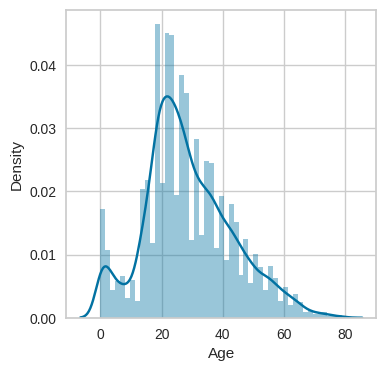

In [367]:
plt.figure(figsize = (4,4))
sns.distplot(data_2.Age)

In [368]:
data_2['Age'].describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

***impute using mean value***

In [369]:
data_2['Age'] = data_2['Age'].fillna(data_2['Age'].mean().round())

We categorize Age

- 0-10 years: Children
- 11-20 years: Teenagers
- 21-30 years: Young adults
- 31-40 years: Adults
- 41-60 years: Middle-aged adults
- 61-80 years: Older adults

In [370]:
data_2['Age'] = data_2['Age'].replace(range(0,11),'Children')
data_2['Age'] = data_2['Age'].replace(range(11,21),'Teenagers')
data_2['Age'] = data_2['Age'].replace(range(21,31),'Young adults')
data_2['Age'] = data_2['Age'].replace(range(31,41),'Adults')
data_2['Age'] = data_2['Age'].replace(range(41,61),'Middle-aged adults')
data_2['Age'] = data_2['Age'].replace(range(61,80),'Older adults')

- RoomService - FoodCourt - ShoppingMall - Spa - VRDeck

***impute using mean value***

In [371]:
for col in ['RoomService',
            'FoodCourt',
            'ShoppingMall',
            'Spa',
            'VRDeck'
           ]:
    data_2[col] = data_2[col].fillna(data_2[col].mean().round())

In [372]:
#Save
data_3 =  data_2.copy()

### **Encoding Categoricals**

In [374]:
enc = LabelEncoder()
for column in data_3.select_dtypes(object).columns:
    data_3[column] = enc.fit_transform(data_3[column])
    
for column in data_3.select_dtypes(bool).columns:
    data_3[column] = data_3[column].astype(int)
    
target = target.astype(int)

In [509]:
data_4 = data_3.copy()

### Final Split

In [510]:
train_final = (data_4.loc[:train.index.max(),:]).copy()
test_final  = (data_4.loc[train.index.max()+1:,:].reset_index(drop = True)).copy()

## 3) **Model Selection**

In [511]:
setup(data = pd.concat([train_final, target], axis = 1), target = 'Transported')
compare_models()

,Description,Value
0,Session id,6765
1,Target,Transported
2,Target type,Binary
3,Original data shape,"(8693, 15)"
4,Transformed data shape,"(8693, 15)"
5,Transformed train set shape,"(6085, 15)"
6,Transformed test set shape,"(2608, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7982,0.8938,0.8042,0.7971,0.8005,0.5963,0.5966,12.2500
gbc,Gradient Boosting Classifier,0.7975,0.8878,0.8255,0.7842,0.8042,0.5949,0.5960,0.7260
ada,Ada Boost Classifier,0.7921,0.8771,0.8248,0.7767,0.7999,0.5840,0.5854,0.3820
lr,Logistic Regression,0.7885,0.8704,0.8114,0.7786,0.7945,0.5768,0.5776,1.1690
rf,Random Forest Classifier,0.7883,0.8715,0.7550,0.8118,0.7822,0.5769,0.5785,0.7820
et,Extra Trees Classifier,0.7801,0.8451,0.7429,0.8057,0.7728,0.5605,0.5624,0.8990
ridge,Ridge Classifier,0.7592,0.0000,0.7175,0.7860,0.7500,0.5188,0.5210,0.0800
lda,Linear Discriminant Analysis,0.7592,0.8471,0.7175,0.7860,0.7500,0.5188,0.5210,0.0840
knn,K Neighbors Classifier,0.7555,0.8169,0.7866,0.7430,0.7641,0.5107,0.5117,0.1530
dt,Decision Tree Classifier,0.7329,0.7329,0.7360,0.7342,0.7350,0.4659,0.4660,0.1070


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6765, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [512]:
from sklearn.ensemble import GradientBoostingClassifier

### **Hyper-Parameter Search**

- **GradientBoostingClassifier**

In [1]:
'''
param_grid = {'max_depth': [5,7,9],
              'learning_rate':[0.01,0.1,0.2],
              'max_features':[4,6,8,10,12,14]
              }

gbc_model = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring="accuracy", cv=5)
gbc_model.fit(train_final, target)
print("Best score = %f, Best parameters = %s" % (1. - gbc_model.best_score_, gbc_model.best_params_))
'''

'\nparam_grid = {\'max_depth\': [5,7,9],\n              \'learning_rate\':[0.01,0.1,0.2],\n              \'max_features\':[4,6,8,10,12,14]\n              }\n\ngbc_model = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring="accuracy", cv=5)\ngbc_model.fit(train_final, target)\nprint("Best score = %f, Best parameters = %s" % (1. - gbc_model.best_score_, gbc_model.best_params_))\n'

In [505]:
gbc_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features=12)

gbc_model.fit(train_final, target)
print('Acuraccy = {}'.format(gbc_model.score(train_final,target)))


Acuraccy = 0.8621879673300357


### Learning Curve

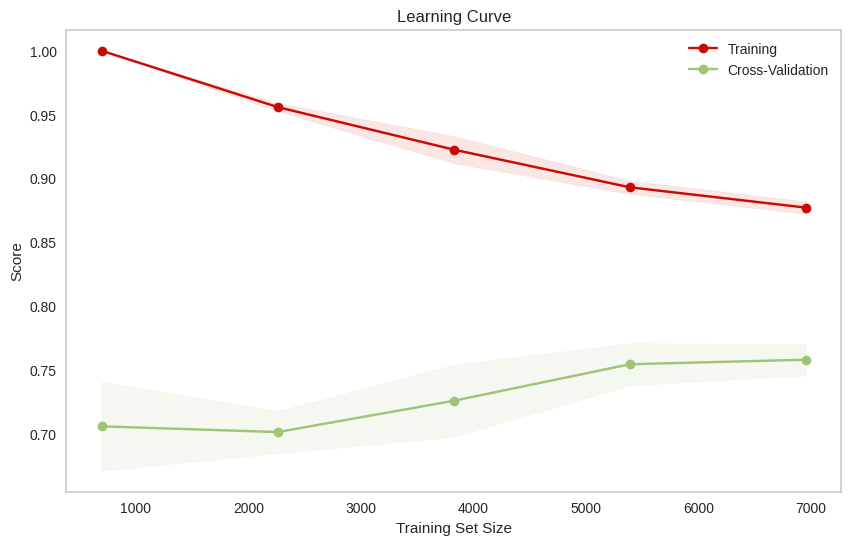

In [506]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation")
    
    plt.legend(loc="best")
    plt.show()

# Use the plot_learning_curve function passing your estimator (model), X (training data), and y (training labels)
plot_learning_curve(gbc_model, train_final, target)

In [507]:
final_predictions = gbc_model.predict(test_final)
final_predictions = final_predictions.astype(bool)
submission = pd.concat([PassengerId, pd.Series(final_predictions, name = 'Transported')], axis= 1)
submission.to_csv('./submission_predictions.csv',index=False, header= True)